In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cross_validation import cross_val_score
import metrics
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from progressbar import ProgressBar
import data_grab
from time import time
from sklearn.decomposition import TruncatedSVD

from sklearn.externals import joblib
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer
from multiprocessing import Pool, Process, Manager

plt.rcParams["figure.figsize"] = (10, 8)

In [3]:
def contest_metric(numpy_array_predictions, numpy_array_actual_values):
    return metrics.weighted_rmsle(numpy_array_predictions, numpy_array_actual_values,
            weights=metrics.KEEPING_IT_CLEAN_WEIGHTS)

In [4]:
def contest_scoring(X, y, pipeline):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    s1 = pipeline.fit(X_train, y_train['score_lvl_1']).predict(X_test)
    s2 = pipeline.fit(X_train, y_train['score_lvl_2']).predict(X_test)
    s3 = pipeline.fit(X_train, y_train['score_lvl_3']).predict(X_test)
    results = np.dstack((s1, s2, s3))
    score = contest_metric(np.round(results[0]), np.array(y_test))
    print("Contest score of {}".format(score))
    return score

In [5]:
from sklearn.metrics import accuracy_score

def raw_scoring(p1, p2, p3, ytrue):
    '''since cross_val_score doesn't allow you to round the results beforehand. also for pymc3 and other non-sklearn models'''
    score1 = accuracy_score(ytrue['score_lvl_1'], np.clip(np.round(p1), 0, np.inf))
    print("Level 1 accuracy score of {}".format(score1))
    score2 = accuracy_score(ytrue['score_lvl_2'],np.clip(np.round(p2), 0, np.inf))
    print("Level 2 accuracy score of {}".format(score2))
    score3 = accuracy_score(ytrue['score_lvl_3'], np.clip(np.round(p3), 0, np.inf))
    print("Level 3 accuracy score of {}".format(score3))
    
    results = np.dstack((p1, p2, p3))[0]
    rounded = np.clip(np.round(results), 0, np.inf)
    score = contest_metric(rounded, np.array(ytrue))
    print("Contest score of {}".format(score))
    
    compare = pd.concat([pd.DataFrame(np.concatenate((results, rounded), axis=1)), ytrue.reset_index(drop=True)], axis=1)
    compare.columns = ['pred1','pred2','pred3','round1','round2','round3','true1','true2','true3']
    compare['offset1'] = compare.round1-compare.true1
    compare['offset2'] = compare.round2-compare.true2
    compare['offset3'] = compare.round3-compare.true3
        
    return score1, score2, score3, score, compare.head(10)

    
def raw_fit(X, y, pipeline):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
    
    p1 = pipeline.fit(xtrain, ytrain['score_lvl_1']).predict(xtest)
    p2 = pipeline.fit(xtrain, ytrain['score_lvl_2']).predict(xtest)
    p3 = pipeline.fit(xtrain, ytrain['score_lvl_3']).predict(xtest)
        
    return p1, p2, p3, ytest

In [6]:
def extract_features(df):
    features = df.drop(['score_lvl_1', 'score_lvl_2', 'score_lvl_3'], axis=1)
    response = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']].astype(np.int8)
    
    return features, response

In [7]:
combo = pd.read_pickle('pickle_jar/pre-pivot_all_review_combo_365')
# df = pd.read_pickle('pickle_jar/pre-pivot_365')
# df = pd.read_pickle('pickle_jar/pre-pivot_all_non_review')
df = pd.read_pickle('pickle_jar/post-pivot_non_review_data_365')

## convert train dataframe to 365 days and prepare for pivot

In [79]:
df = data_grab.get_selects('train')

In [80]:
# not getting rid of everything. not getting rid of ancient reviews if they correspond with an ancient inspection.
# just getting rid of ancient reviews in relation to a specific inspection
df = df[df.review_delta <= 365]

In [81]:
# making a column that enumerates the sorted review delta.
# removes any nans (usually marked as such because the reviews happend after an inspection date) beforehand.
# this can completely remove a restaurant if it has no reviews left after nan drop. might add back in later
df = df.sort('review_delta')
df2 = df.dropna(subset=['review_delta']).groupby('inspection_id').cumcount()

In [82]:
# df3 = pd.concat([df.dropna(subset=['review_delta']), df2], axis=1)
df = pd.concat([df.dropna(subset=['review_delta']), df2], axis=1)

In [83]:
df = df.rename(columns={0:'enumerated_review_delta'})
del df2

In [84]:
# add back in the restaurants that were completely removed because none of their reviews were
# not a significant loss in the number of restaurants. going to just leave it out for now
# mask = list(set(df.restaurant_id) - set(df3.restaurant_id))
# pd.concat([df[df.restaurant_id.isin(mask)], df3])

In [85]:
df.shape

(500936, 138)

In [86]:
just_review_data = df[[ 
 'inspection_id',
 'enumerated_review_delta',
#  'review_id',
 'review_delta', 
#  'review_date', 
 'review_stars',
 'review_text',
#  'user_id',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
#  'user_fans',
 'user_review_count',
#  'user_votes_cool',
#  'user_votes_funny',
#  'user_votes_useful',
 'user_yelping_since_delta',
#  'review_year',
#  'review_month',
#  'review_day',
#  'review_dayofweek',
#  'review_quarter',
#  'review_dayofyear',
 'user_ever_elite',
 ]]

In [88]:
df.drop([ 'review_delta',
 'review_stars',
 'review_text',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
 'user_fans',
 'user_review_count',
 'user_votes_cool',
 'user_votes_funny',
 'user_votes_useful',
 'user_yelping_since_delta',
 'user_ever_elite'], axis=1, inplace=True)
df.drop(['review_date',
 'review_id',
 'user_id',
 'user_compliments_cool',
 'user_compliments_cute',
 'user_compliments_funny',
 'user_compliments_hot',
 'user_compliments_list',
 'user_compliments_more',
 'user_compliments_note',
 'user_compliments_photos',
 'user_compliments_plain',
 'user_compliments_profile',
 'user_compliments_writer',
 'user_name', 'review_year',
 'review_month',
 'review_day',
 'review_dayofweek',
 'review_quarter',
 'review_dayofyear','user_most_recent_elite_year_delta',], axis=1, inplace=True)
df.drop('enumerated_review_delta', axis=1, inplace=True)

In [90]:
g = df.groupby('inspection_id').first()

In [92]:
g.reset_index().sort('inspection_id').to_pickle('pickle_jar/post-pivot_non_review_data_365')

In [33]:
df.sort('inspection_id').to_pickle('pickle_jar/pre-pivot_all_non_review')

In [44]:
# this removes all the nans left. review stars as nans because reviews and tips combined and tips didnt give a star rating
# planning to treat this as a categorical variable later so making it zero shouldnt affect anything
just_review_data.review_stars = just_review_data.review_stars.fillna(0)

In [45]:
just_review_data.sort(['inspection_id', 'enumerated_review_delta']).to_pickle('pickle_jar/pre-pivot_365')

## combine sentiment and similarity with pre-pivot 365 review related data into one dataframe for pivoting

In [46]:
sentiment = pd.read_pickle('pickle_jar/review_text_sentiment_pivot')
similarity = pd.read_pickle('pickle_jar/similarity_length_pivot')

In [47]:
sentiment = sentiment[['inspection_id', 'enumerated_review_delta', 'polarity', 'subjectivity', 'neg', 'neu', 'pos', 'compound']]

In [48]:
similarity.drop(['review_delta', 'review_stars', 'review_text', 'review_votes_cool', 'review_votes_funny',
                 'review_votes_useful', 'user_average_stars', 'user_fans', 'user_review_count', 'user_votes_cool', 
                 'user_votes_funny', 'user_votes_useful', 'user_yelping_since_delta', 'user_ever_elite',
                 'preprocessed_review_text'], axis=1, inplace=True)

In [49]:
combo = pd.merge(sentiment, similarity, on=['inspection_id', 'enumerated_review_delta'])

In [50]:
just_review_data.drop('review_text', axis=1, inplace=True)

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [51]:
combo = pd.merge(combo, just_review_data, on=['inspection_id', 'enumerated_review_delta'])

In [56]:
combo.sort(['inspection_id', 'enumerated_review_delta']).reset_index(drop=True).to_pickle('pickle_jar/pre-pivot_all_review_combo_365')

In [7]:
# sim_length = lambda x: len(np.where(x > 0.7)[0])
def sim_length(x):
    try:
        return len(np.where(x > 0.6)[0])
    except:
        return x

sim_length_list = []
topics = ['manager', 'supervisor', 'training', 'safety', 'disease', 'ill', 'sick', 'poisoning', 'poison', 'hygiene', 'raw', 'undercooked', 'cold', 'clean', 'sanitary', 'wash', 'jaundice', 'yellow', 'hazard', 'inspection', 'violation', 'gloves', 'hairnet', 'nails', 'jewelry', 'sneeze', 'cough', 'runny', 'illegal', 'rotten', 'dirty', 'mouse', 'cockroach', 'contaminated', 'gross', 'disgusting', 'stink', 'old', 'parasite', 'bacteria', 'reheat', 'frozen', 'broken', 'drip', 'bathroom', 'toilet', 'leak', 'trash', 'dark', 'lights', 'dust', 'puddle', 'pesticide', 'bugs', 'mold']
pbar = ProgressBar(maxval=len(topics)).start()
for index, i in enumerate(topics):
    combo[i] = combo[i].apply(sim_length)
#     sim_length_list.append(combo[i].apply(sim_length).tolist())
    pbar.update(index)
pbar.finish()

# combo.nails.apply(sim_length).value_counts()
# combo[['inspection_id', 'enumerated_review_delta', 'polarity', 'subjectivity']][combo.nails.apply(sim_length) == 1]
# df[(df.inspection_id == 28790) & (df.enumerated_review_delta == 7)].review_text.tolist()

100% (55 of 55) |#########################| Elapsed Time: 0:02:17 Time: 0:02:17


## trustworthiness index

In [22]:
def log_it(x):
#     second_min = x[x != x.min()].min()
#     x.replace(x.min(), second_min/2, inplace=True)
#     return np.log(x)
    x = x + 1
    return np.log(x)

norm = Normalizer()

In [23]:
# making trustworthiness feature
trust = combo[['inspection_id', 'enumerated_review_delta', 'subjectivity',
 'review_votes_cool',
 'review_votes_funny',
 'review_votes_useful',
 'user_average_stars',
 'user_review_count',
 'user_yelping_since_delta',
 'user_ever_elite']]

In [24]:
trust['objectivity'] = 1 - trust.subjectivity
trust.drop('subjectivity', axis=1, inplace=True)

# trust['review_votes']  = log_it(trust.review_votes_useful)*3 + log_it(trust.review_votes_funny)*2 + log_it(trust.review_votes_cool)
trust['review_votes'] = log_it(trust.review_votes_useful*3 + trust.review_votes_funny*2 + trust.review_votes_cool)
# trust['review_votes'] = log_it(trust.review_votes_useful) + log_it(trust.review_votes_funny) + log_it(trust.review_votes_cool)
trust.drop(['review_votes_cool', 'review_votes_funny', 'review_votes_useful'], axis=1, inplace=True)

trust.user_yelping_since_delta.replace(0, 1, inplace=True)
normalized_history = trust.user_yelping_since_delta / trust.user_yelping_since_delta.max()
normalized_review_count = trust.user_review_count / trust.user_review_count.max()
# fixes where someone who wrote 2 reviews in two days would get a higher score than someone who wrote 1000 reviews in 2000 days
trust['user_activity_level'] = normalized_review_count / (1.1 - normalized_history) + trust.user_ever_elite
trust.drop(['user_yelping_since_delta', 'user_review_count', 'user_ever_elite'], axis=1, inplace=True)

trust['anger_index'] = trust.user_activity_level / (trust.user_average_stars + 0.1)

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

In [25]:
trust['trust_index'] = trust.objectivity * trust.user_activity_level

/Users/amangum/anaconda/envs/datasci/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [26]:
trust.sort('anger_index', ascending=False).head()

,inspection_id,enumerated_review_delta,user_average_stars,objectivity,review_votes,user_activity_level,anger_index,trust_index
71213,4807,6,3.66,0.358750,1.386294,3.054670,0.812412,1.095863
132865,8915,9,3.66,0.500000,0.693147,3.054670,0.812412,1.527335
327093,22045,1,3.66,0.500000,0.693147,3.054670,0.812412,1.527335
393355,26491,4,3.66,0.241667,0.000000,3.051616,0.811600,0.737474
419315,28282,56,3.66,0.425000,1.098612,3.051616,0.811600,1.296937


## pivot reviews out

In [74]:
combo.set_index(['inspection_id', 'enumerated_review_delta']).head()

polarity  subjectivity    neg    neu  \
inspection_id enumerated_review_delta                                         
0             0                        0.222946      0.713393  0.000  0.783   
              1                        0.237602      0.495938  0.008  0.839   
1             0                        0.189981      0.518578  0.000  0.853   
              1                        0.115152      0.507576  0.030  0.776   
              2                        0.324259      0.577407  0.000  0.686   

                                         pos  compound  \
inspection_id enumerated_review_delta                    
0             0                        0.217    0.9636   
              1                        0.153    0.9926   
1             0                        0.147    0.9537   
              1                        0.194    0.9421   
              2                        0.314    0.9716   

                                                                                 manager  \
inspection_id enumerated_review_delta                                                      
0             0                        [0.0823464, 0.076757, 0.0739208, 0.0398531, 0....   
              1                        [0.144015, 0.123933, 0.113317, 0.111903, 0.102...   
1             0                        [0.233784, 0.150149, 0.130027, 0.124982, 0.115...   
              1                        [0.130773, 0.117207, 0.116062, 0.0985389, 0.09...   
              2                        [0.190561, 0.1286, 0.126998, 0.120387, 0.12038...   

                                                                              supervisor  \
inspection_id enumerated_review_delta                                                      
0             0                        [0.0982185, 0.0774828, 0.0723427, 0.0305749, 0...   
              1                        [0.138609, 0.126632, 0.125301, 0.114626, 0.109...   
1             0                        [0.322755, 0.182528, 0.16596, 0.140622, 0.1386...   
              1                        [0.267121, 0.145095, 0.138609, 0.112187, 0.098...   
              2                        [0.23219, 0.154479, 0.139179, 0.138609, 0.1190...   

                                                                                training  \
inspection_id enumerated_review_delta                                                      
0             0                        [0.127395, 0.114109, 0.0926586, 0.0815057, 0.0...   
              1                        [0.180208, 0.153162, 0.143042, 0.119608, 0.117...   
1             0                        [0.37962, 0.310816, 0.199297, 0.184256, 0.1809...   
              1                        [0.180208, 0.153395, 0.153162, 0.138352, 0.137...   
              2                        [0.41236, 0.251453, 0.196399, 0.196399, 0.1802...   

                                                                                  safety  \
inspection_id enumerated_review_delta                                                      
0             0                        [0.0901909, 0.0618174, 0.0530563, 0.0453497, 0...   
              1                        [0.201867, 0.174458, 0.174458, 0.174458, 0.169...   
1             0                        [0.287903, 0.239384, 0.201867, 0.194453, 0.187...   
              1                        [0.201867, 0.174458, 0.174458, 0.123344, 0.115...   
              2                        [0.242597, 0.223125, 0.223125, 0.201867, 0.139...   

                                            ...        \
inspection_id enumerated_review_delta       ...         
0             0                             ...         
              1                             ...         
1             0                             ...         
              1                             ...         
              2                             ...         

                                                                                    mold  \
inspec

In [45]:
combo.pivot(index='inspection_id', columns='enumerated_review_delta').head()
# combo.set_index(['inspection_id', 'enumerated_review_delta']).unstack(1).head()
# combo.pivot_table(index='inspection_id', columns='enumerated_review_delta').head()
# df.groupby('inspection_id').max().head()

polarity                                          \
enumerated_review_delta       0         1         2         3         4     
inspection_id                                                               
0                        0.222946  0.237602       NaN       NaN       NaN   
1                        0.189981  0.115152  0.324259       NaN       NaN   
2                        0.005025 -0.234226  0.700000  0.158102  0.019551   
7                        0.193750       NaN       NaN       NaN       NaN   
8                        0.214286 -0.059524  0.166833  0.030000  0.259574   

                                                                ...   \
enumerated_review_delta       5     6         7         8   9   ...    
inspection_id                                                   ...    
0                             NaN   NaN       NaN       NaN NaN ...    
1                             NaN   NaN       NaN       NaN NaN ...    
2                        0.255694  0.25  0.343308  0.173016 NaN ...    
7                             NaN   NaN       NaN       NaN NaN ...    
8                        0.500000   NaN       NaN       NaN NaN ...    

                        user_ever_elite                                     \
enumerated_review_delta             435  436  437  438  439  440  441  442   
inspection_id                                                                
0                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
7                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
8                                   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                                   
enumerated_review_delta  443  444  
inspection_id                      
0                        NaN  NaN  
1                        NaN  NaN  
2                        NaN  NaN  
7                        NaN  NaN  
8                        NaN  NaN  

[5 rows x 31150 columns]

In [ ]:
df['review_stars'] = df.review_stars.fillna(0).astype('category')
df.restaurant_attributes_price_range = df.restaurant_attributes_price_range.fillna(df.restaurant_attributes_price_range.median())

In [13]:
from sklearn.decomposition import PCA, TruncatedSVD

def pivot_feature(df, feature, limit=None, decomp='lsa', decomp_features=100, fill='median'):
    # make the large dataframe faster to handle on pivot
    temp = df[['inspection_id', 'enumerated_review_delta'] + [feature]]
    
    # pivot so that each inspection id only has one observation with each review a feature for that observation
    pivoted_feature = temp.pivot('inspection_id', 'enumerated_review_delta')[feature]
    
              
    # pivoting creates a number of empty variables when they have less than the max number of reviews        
    if fill == 'median':
        fill_empties = lambda x: x.fillna(x.median())
    elif fill == 'mean':
        fill_empties = lambda x: x.fillna(x.mean())
    elif fill == 0:
        fill_empties = lambda x: x.fillna(0)
    elif fill == 'inter':
        fill_empties = lambda x: x.interpolate()
    elif fill == None:
        fill_empties = lambda x: x
    else:
        raise Exception
    
    pivoted_feature = pivoted_feature.apply(fill_empties, axis=1)
              
    if decomp == 'lsa':
        decomposition = TruncatedSVD(decomp_features)
    elif decomp == 'pca':
        decomposition = PCA(decomp_features)
    elif decomp == None:
        pass
    else:
        raise Exception
    
    if not limit:
        try:
            return decomposition.fit_transform(pivoted_feature)
        except:
            return pivoted_feature
    else:
        try:
            return decomposition.fit_transform(pivoted_feature)[: , 0:limit]
        except:
            return pivoted_feature[[i for i in range(limit)]]
    
def pivot_test(levels):
    pool = Pool()
    score_list = pool.map(pivot_pool, range(1,levels))
    pool.close()
    pool.join()
    for i in ['lsa', 'pca']:
        X = pivot_feature(pv_df, pv_feature, limit=None, decomp=i)  
        xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
        p = RandomForestClassifier(n_jobs=-1, random_state=42).fit(xtrain, ytrain[pv_score]).predict(xtest)
        score = accuracy_score(ytest[pv_score], np.clip(np.round(p), 0, np.inf))
        score_list.append(score)
    return score_list
    
def pivot_pool(i):
    X = pivot_feature(pv_df, pv_feature, limit=i, decomp=None)
    global y
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42)
    p = RandomForestClassifier(n_jobs=-1, random_state=42).fit(xtrain, ytrain[pv_score]).predict(xtest)
    score = accuracy_score(ytest[pv_score], np.clip(np.round(p), 0, np.inf))
    return score


In [11]:
flist = ['nails', 'jewelry', 'sneeze', 'cough', 'runny', 'illegal', 'rotten', 'dirty', 'mouse', 'cockroach', 'contaminated', 'gross', 'disgusting', 'stink', 'old', 'parasite', 'bacteria', 'reheat', 'frozen', 'broken', 'drip', 'bathroom', 'toilet', 'leak', 'trash', 'dark', 'lights', 'dust', 'puddle', 'pesticide', 'bugs', 'mold']
pv_df = combo
pv_feature = 'nails'
pv_score = 'score_lvl_1'
# for i in flist:
#     global pv_feature
#     pv_feature = i
score_list = pivot_test(100)
indexed = np.argsort(score_list)
print("Best level of {} with a score of {} for {}".format(indexed[-1] + 1, np.round(score_list[indexed[-1]], 4), i))

Best level of 1 with a score of 0.2061 for mold


In [11]:
tfidf = joblib.load('pickle_jar/tfidf_preprocessed_ngram3_sublinear_1mil_pivot_365')

lsa = TruncatedSVD(2)
lsa_tfidf = lsa.fit_transform(tfidf)
tfidf_pivot = pd.concat([combo[['inspection_id', 'enumerated_review_delta']], pd.DataFrame(lsa_tfidf)], axis=1)

In [ ]:
tfidf_pivot = pd.read_pickle('pickle_jar/lsa_tfidf_2mil_pivot_365')

In [ ]:
tfidf.shape

In [207]:
# combo[['inspection_id', 'enumerated_review_delta', 'manager']].pivot('inspection_id', 'enumerated_review_delta')
def test(x):
    try:
        return x[0]
    except:
        return x

combo['t1'] = combo.drip.apply(test)
combo['t2'] = combo.manager.apply(test)
combo['t3'] = combo.violation.apply(test)

In [484]:
topics = ['manager', 'supervisor', 'training', 'safety', 'disease', 'ill', 'sick', 'poisoning', 'poison', 'hygiene', 'raw', 'undercooked', 'cold', 'clean', 'sanitary', 'wash', 'jaundice', 'yellow', 'hazard', 'inspection', 'violation', 'gloves', 'hairnet', 'nails', 'jewelry', 'sneeze', 'cough', 'runny', 'illegal', 'rotten', 'dirty', 'mouse', 'cockroach', 'contaminated', 'gross', 'disgusting', 'stink', 'old', 'parasite', 'bacteria', 'reheat', 'frozen', 'broken', 'drip', 'bathroom', 'toilet', 'leak', 'trash', 'dark', 'lights', 'dust', 'puddle', 'pesticide', 'bugs', 'mold']

X = pivot_feature(combo, feature='polarity', limit=5, decomp=None)
for i in topics:
    print i
    new_X = pivot_feature(combo, feature=i, limit=5, decomp=None)
    X = np.hstack((X, new_X))

manager
supervisor
training
safety
disease
ill
sick
poisoning
poison
hygiene
raw
undercooked
cold
clean
sanitary
wash
jaundice
yellow
hazard
inspection
violation
gloves
hairnet
nails
jewelry
sneeze
cough
runny
illegal
rotten
dirty
mouse
cockroach
contaminated
gross
disgusting
stink
old
parasite
bacteria
reheat
frozen
broken
drip
bathroom
toilet
leak
trash
dark
lights
dust
puddle
pesticide
bugs
mold


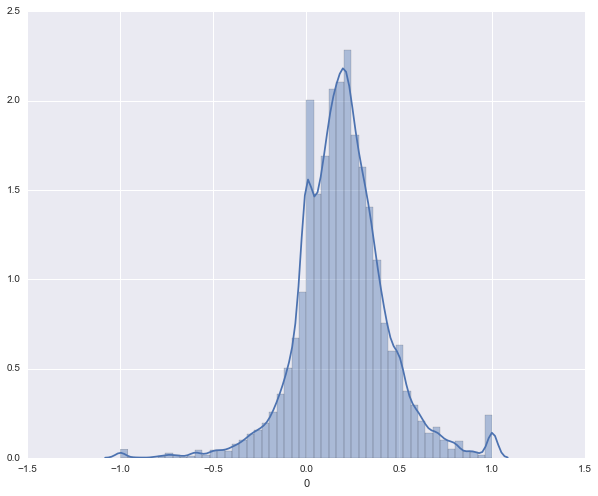

In [41]:
sns.distplot(X[0])

In [20]:
X = pivot_feature(combo, feature='polarity', limit=5, decomp=None)
# X = combo.groupby('inspection_id')['polarity'].mean()
y = df[['score_lvl_1', 'score_lvl_2', 'score_lvl_3']]

In [460]:
# combine two features
X2 = pivot_feature(combo, feature='pos', limit=11, decomp=None)
X3 = pivot_feature(combo, feature='compound', limit=5, decomp=None)
# X = np.hstack((X, X2))
X = np.hstack((X, X2, X3))

In [461]:
# lb = LabelBinarizer(sparse_output=True)
# m = lb.fit_transform(df.restaurant_id)
X = np.hstack((X, pd.get_dummies(df.restaurant_id)))

In [21]:
# combine X with non-review features
X = np.hstack((X, df[['inspection_month']])) # as numerical
# X = np.hstack((X, pd.get_dummies(df.inspection_month))) # as categorical
# X = np.hstack((X, pd.get_dummies(df.inspection_dayofweek))) # as categorical
# X = np.hstack((X, pd.get_dummies(df.inspection_year))) # as categorical

In [22]:
def add_bool(df, columns):
    first = columns.pop(0)
    t0 = df[first].astype(int)

    for i in columns:
        temp = df[i].astype(int)
        t0 = pd.concat([t0, temp], axis=1)
    return t0

# m = add_bool(df, ['restaurant_attributes_accepts_credit_cards', 'restaurant_attributes_coat_check', 'restaurant_attributes_good_for_dancing', 'restaurant_attributes_good_for_groups', 'restaurant_attributes_good_for_latenight', 'restaurant_attributes_happy_hour', 'restaurant_attributes_has_tv', 'restaurant_attributes_outdoor_seating', 'restaurant_attributes_take_out',  'restaurant_attributes_takes_reservations', 'restaurant_attributes_waiter_service', 'restaurant_attributes_wheelchair_accessible'])
m = add_bool(df, ['restaurant_attributes_accepts_credit_cards', 'restaurant_attributes_byob', 'restaurant_attributes_caters', 'restaurant_attributes_coat_check', 'restaurant_attributes_corkage', 'restaurant_attributes_delivery', 'restaurant_attributes_dietary_restrictions_dairy_free', 'restaurant_attributes_dietary_restrictions_gluten_free', 'restaurant_attributes_dietary_restrictions_halal', 'restaurant_attributes_dietary_restrictions_kosher', 'restaurant_attributes_dietary_restrictions_soy_free', 'restaurant_attributes_dietary_restrictions_vegan', 'restaurant_attributes_dietary_restrictions_vegetarian', 'restaurant_attributes_dogs_allowed', 'restaurant_attributes_drive_thr', 'restaurant_attributes_good_for_dancing', 'restaurant_attributes_good_for_groups', 'restaurant_attributes_good_for_breakfast', 'restaurant_attributes_good_for_brunch', 'restaurant_attributes_good_for_dessert', 'restaurant_attributes_good_for_dinner', 'restaurant_attributes_good_for_latenight', 'restaurant_attributes_good_for_lunch', 'restaurant_attributes_good_for_kids', 'restaurant_attributes_happy_hour', 'restaurant_attributes_has_tv', 'restaurant_attributes_open_24_hours', 'restaurant_attributes_order_at_counter', 'restaurant_attributes_outdoor_seating',  'restaurant_attributes_payment_types_amex', 'restaurant_attributes_payment_types_cash_only', 'restaurant_attributes_payment_types_discover', 'restaurant_attributes_payment_types_mastercard', 'restaurant_attributes_payment_types_visa', 'restaurant_attributes_take_out',  'restaurant_attributes_takes_reservations', 'restaurant_attributes_waiter_service', 'restaurant_attributes_wheelchair_accessible', ])
X = np.hstack((X, m))

In [23]:
ambience_dum = pd.get_dummies(df.restaurant_ambience)[['divey', 'trendy']]
alcohol_dum = pd.get_dummies(df.restaurant_attributes_alcohol)['full_bar']
attire_dum = pd.get_dummies(df.restaurant_attributes_attire)['dressy']
noise_dum = pd.get_dummies(df.restaurant_attributes_noise_level)['very_loud']
smoke_dum = pd.get_dummies(df.restaurant_attributes_smoking)['outdoor']
music_dum = pd.get_dummies(df.restaurant_music)[['dj', 'live']]
park_dum = pd.get_dummies(df.restaurant_parking)['street']
wifi_dum = pd.get_dummies(df.restaurant_attributes_wifi)['no']
X = np.hstack((X, np.array(pd.concat([ambience_dum, alcohol_dum, attire_dum, noise_dum, smoke_dum, music_dum, park_dum, wifi_dum], axis=1))))

In [24]:
def special_categories_to_matrix(df, cats):
    # need to do it like this because pd.merge causes a memory overload
    t0 = pd.get_dummies(df[cats[0]])
    cats.pop(0)
    for i in cats:
        new_dummies = pd.get_dummies(df[i])
        pbar = ProgressBar(maxval=len(new_dummies.columns)).start()
        for index, column in enumerate(new_dummies.columns):
            if column not in t0.columns:
                t0 = pd.concat([t0, new_dummies[column]], axis=1)
            else:
                t0[column] = t0[column] + new_dummies[column]
            pbar.update(index)
        pbar.finish()
    return t0

cats = ['restaurant_category_1', 'restaurant_category_2', 'restaurant_category_3', 'restaurant_category_4', 'restaurant_category_5', 'restaurant_category_6', 'restaurant_category_7']
m = special_categories_to_matrix(df, cats)
X = np.hstack((X, m))


100% (99 of 99) |#########################| Elapsed Time: 0:00:01 Time: 0:00:01
100% (87 of 87) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (51 of 51) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (24 of 24) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (11 of 11) |#########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (2 of 2) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


In [25]:
cats = ['restaurant_neighborhood_1', 'restaurant_neighborhood_2', 'restaurant_neighborhood_3']
m = special_categories_to_matrix(df, cats)
X = np.hstack((X, m))

100% (9 of 9) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00
100% (1 of 1) |###########################| Elapsed Time: 0:00:00 Time: 0:00:00


In [26]:
# combine X with tfidf
X = np.hstack((X, tfidf_pivot.groupby('inspection_id').mean()))

In [27]:
X.shape

(24430, 243)

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import BayesianRidge

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression, f_classif, SelectFpr

t0 = time()


estimator_list = [
#     LinearRegression(), 
#     SGDClassifier(n_jobs=-1, random_state=42), 
#     Perceptron(n_jobs=-1, random_state=42),  # gets some nuances
    SGDRegressor(), # gets some nuances
    RandomForestClassifier(n_jobs=-1, random_state=42), 
    RandomForestRegressor(n_jobs=-1, random_state=42),
#     BayesianRidge(), 
#     KNeighborsClassifier(),
#     KNeighborsRegressor(),  # gets some nuances
# DecisionTreeClassifier(),
# DecisionTreeRegressor(),
# GaussianNB(),
# MultinomialNB(),
# LinearSVC(random_state=42),
]

for estimator in estimator_list:
    pipeline = Pipeline([
        ('zero_variance_removal', VarianceThreshold()),
        ('k_best', SelectKBest(score_func=f_classif, k=100)),
#         ('no_negative', MinMaxScaler()),
#         ('normalizer', Normalizer(norm='l2')), #  for text classification and clustering
#         ('normalizer', Normalizer(copy=False)),
#         ('scaler', StandardScaler()),
#         ('scaler', StandardScaler(with_mean=False)), #  for sparse matrix
        ('clf', estimator),
])
    print estimator
#     for i in range(1,11):
#         print(i)
#         X = pivot_feature(combo, feature='polarity', limit=i, decomp=None)
#         p1,p2,p3,ytest = raw_fit(X, y, pipeline)
#         raw_scoring(p1,p2,p3,ytest)
    p1,p2,p3,ytest = raw_fit(X, y, pipeline)
    raw_scoring(p1,p2,p3,ytest)
    print('\n')


print("{} seconds elapsed".format(time()-t0))

#everything except restauarnt id kbest 100
# Level 1 accuracy score of 0.430091683039
# Level 2 accuracy score of 0.773739358219
# Level 3 accuracy score of 0.64047151277
# Contest score of 1.12942069745

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)
Level 1 accuracy score of 0.110183366077
Level 2 accuracy score of 0.48231827112
Level 3 accuracy score of 0.401440733464
Contest score of 4.98915209096


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
Level 1 accuracy score of 0.430091683039
Level 2 accuracy score of 0.773739358219
Level 3 accuracy score of 0.64047151277
Contest score of 1.12942069745


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
    

In [169]:
# baseline scores if guessing zero
scores = ['score_lvl_1', 'score_lvl_2', 'score_lvl_3']
guess = 0
for index, score in enumerate(scores):
    print("level {}: {}".format(index+1, y[score].value_counts(normalize=True)[guess]))

level 1: 0.206385591486
level 2: 0.711625051167
level 3: 0.553786328285
